<a href="https://colab.research.google.com/github/PKCP-6710120021/240-589-Explainable-AI-XAI-/blob/main/Explainable_AI_(XAI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Explainable AI (XAI)** Student Performance Prediction

# คาดการณ์คะแนนสอบของนักเรียนโดยอิงจากนิสัยการเรียนและการเข้าเรียน

**Dataset**
https://www.kaggle.com/datasets/amrmaree/student-performance-prediction/data

In [40]:
import pandas as pd, numpy as np

path = "/content/student_performance_dataset.csv"
df = pd.read_csv(path)

# ทำ label: Pass_Fail → passed (1/0)
df["passed"] = (df["Pass_Fail"].astype(str).str.strip().str.lower()
                .map({"pass":1, "fail":0})).astype(int)

drop_cols = ["Student_ID", "Pass_Fail", "Final_Exam_Score"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df["passed"]

print("Shape X,y =", X.shape, y.shape)
display(df.head())


Shape X,y = (708, 8) (708,)


,Student_ID,Gender,Study_Hours_per_Week,Attendance_Rate,Past_Exam_Scores,Parental_Education_Level,Internet_Access_at_Home,Extracurricular_Activities,Final_Exam_Score,Pass_Fail,passed
0,S147,Male,31,68.267841,86,High School,Yes,Yes,63,Pass,1
1,S136,Male,16,78.222927,73,PhD,No,No,50,Fail,0
2,S209,Female,21,87.525096,74,PhD,Yes,No,55,Fail,0
3,S458,Female,27,92.076483,99,Bachelors,No,No,65,Pass,1
4,S078,Female,37,98.655517,63,Masters,No,Yes,70,Pass,1


In [41]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for tr, te in sss.split(X, y):
    X_train, X_test = X.iloc[tr], X.iloc[te]
    y_train, y_test = y.iloc[tr], y.iloc[te]

print("y_train:", y_train.value_counts().to_dict())
print("y_test :", y_test.value_counts().to_dict())


y_train: {1: 266, 0: 265}
y_test : {0: 89, 1: 88}


In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# แยกชนิดฟีเจอร์
num_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
cat_cols = [c for c in X_train.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), cat_cols)
    ],
    remainder="drop"
)

models = {}

# Logistic Regression
lr = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])
lr.fit(X_train, y_train)
models["LR"] = lr

# (ตัวเลือก) Decision Tree
tree = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(max_depth=5, class_weight="balanced", random_state=42))
])
tree.fit(X_train, y_train)
models["Tree"] = tree

list(models.keys())


['LR', 'Tree']

In [48]:
from sklearn.metrics import classification_report, roc_auc_score

def eval_model(name, pipe):
    pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:,1]
    print(f"\n==== {name} ====")
    print(classification_report(y_test, pred, digits=3))
    print("ROC-AUC:", roc_auc_score(y_test, proba))

for n,m in models.items():
    eval_model(n,m)



==== LR ====
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        89
           1      1.000     1.000     1.000        88

    accuracy                          1.000       177
   macro avg      1.000     1.000     1.000       177
weighted avg      1.000     1.000     1.000       177

ROC-AUC: 1.0

==== Tree ====
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        89
           1      1.000     1.000     1.000        88

    accuracy                          1.000       177
   macro avg      1.000     1.000     1.000       177
weighted avg      1.000     1.000     1.000       177

ROC-AUC: 1.0


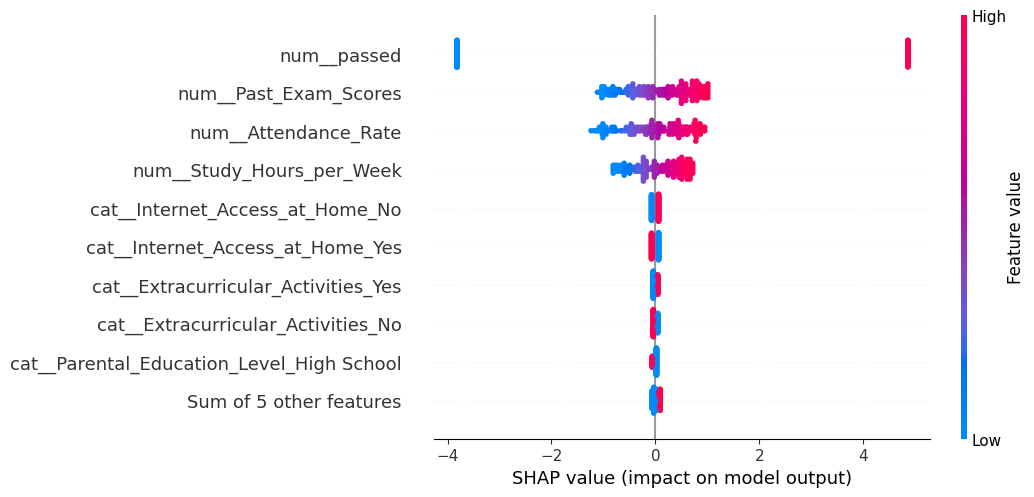

In [49]:
import shap
from scipy import sparse
import numpy as np

pipe_lr = models["LR"]
clf_lr  = pipe_lr.named_steps["clf"]
prep    = pipe_lr.named_steps["prep"]

# แปลง X ให้เป็นตัวเลขล้วน + ชื่อฟีเจอร์
Xtr_enc = prep.transform(X_train)
Xte_enc = prep.transform(X_test)
if sparse.issparse(Xtr_enc): Xtr_enc = Xtr_enc.toarray()
if sparse.issparse(Xte_enc): Xte_enc = Xte_enc.toarray()

try:
    feat_names = list(prep.get_feature_names_out())
except:
    feat_names = [f"f{i}" for i in range(Xtr_enc.shape[1])]

bg = shap.sample(Xtr_enc, 200) if Xtr_enc.shape[0] > 200 else Xtr_enc
expl_lr = shap.LinearExplainer(clf_lr, bg)
shap_lr_raw = expl_lr(Xte_enc)

shap_lr = shap.Explanation(values=shap_lr_raw.values,
                           base_values=shap_lr_raw.base_values,
                           data=Xte_enc,
                           feature_names=feat_names)

# Global summary (beeswarm)
shap.plots.beeswarm(shap_lr, max_display=10)


y_true=0  p_hat=0.003


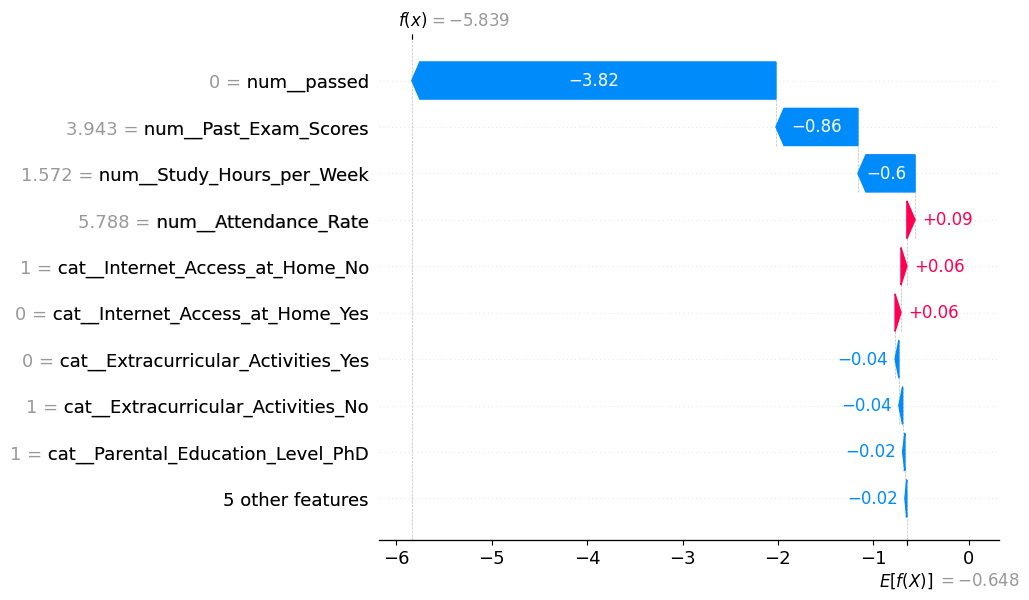

In [50]:
i = 0
print(f"y_true={y_test.iloc[i]}  p_hat={pipe_lr.predict_proba(X_test.iloc[[i]])[0,1]:.3f}")
shap.plots.waterfall(shap_lr[i], max_display=10)
